Predict 'Close' price for PGIM stock based on 5 day rolling average using ARIMA 2,0,2.

Data Transformation: 'Close' reduced to logclose2002.

Error Consideration: predictions appear like replications of the previous cycle. 

Further investigations required: 
    #SARIMA will be used and compared to ARIMA.
        #Consider seasonality of election year (4 year, was there a recession?)
    #Train for Jan 2002-Jan 2016; Test for Jan 2016-Jan2018; compare residual error of SARIMA and ARIMA.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas_datareader import data as web
import plotly
import cufflinks as cf
cf.go_offline()

In [2]:
import datetime
from datetime import date,timedelta

In [3]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import arma_order_select_ic
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

In [4]:
today = date.today().strftime('%Y-%m-%d')
yesterday = date.strftime(date.today() - timedelta(1), '%Y-%m-%d')
friday = date.strftime(date.today() - timedelta(2), '%Y-%m-%d')

In [5]:
base = datetime.date.today()
date_list = [(base - timedelta(2)) + datetime.timedelta(days=x) for x in range(3650)]

In [6]:
date_list = pd.DataFrame(date_list,columns=['Date'])
date_list2 = pd.DataFrame(date_list,columns=['Date'])

In [7]:
date_list = date_list.set_index(date_list['Date'])

In [8]:
date_list = pd.to_datetime(date_list.index)

In [9]:
today,yesterday,friday

('2020-03-22', '2020-03-21', '2020-03-20')

In [10]:
JLGQX = web.DataReader('JLGQX', 'yahoo',start='2016-09-09', end=friday)
RWIEX = web.DataReader('RWIEX', 'yahoo',start='2002-01-01', end=friday)
FVX = web.DataReader('^FVX', 'yahoo',start='2002-01-01', end=friday)
PDBAX = web.DataReader('PDBAX', 'yahoo',start='2002-01-01', end=friday)
HGIYX = web.DataReader('HGIYX', 'yahoo',start='2002-01-01', end=friday)

In [11]:
tickers = ['Treasury 5 Year Index','Large Cap Growth, JPMorgan','Hartford Core Equity Fund Class Y','PGIM Total Return Bond Fund -Class A','American Funds Capital World Growth, R-4']
tickers2002 = ['Treasury 5 Year Index','Hartford Core Equity Fund Class Y','PGIM Total Return Bond Fund -Class A','American Funds Capital World Growth, R-4']

In [12]:
bankstocks = pd.concat([FVX,JLGQX,HGIYX,PDBAX,RWIEX],axis=1,keys=tickers)

In [13]:
bankstocks.columns.names = ['Bank Ticker','Stock Info']

In [14]:
openstocks = bankstocks.xs(key='Open',axis=1,level='Stock Info')

In [15]:
closestocks2002 = bankstocks.xs(key='Close',axis=1,level='Stock Info').loc['2002-01-1':yesterday]
closestocks2016 = bankstocks.xs(key='Close',axis=1,level='Stock Info').loc['2016-10-01':yesterday]

In [16]:
closestocks2002.drop(['Large Cap Growth, JPMorgan'],axis=1,inplace=True)

In [17]:
stockrollingaverage2002 = closestocks2002.rolling(window=30).mean()
stockrollingaverage2016 = closestocks2016.rolling(window=30).mean()

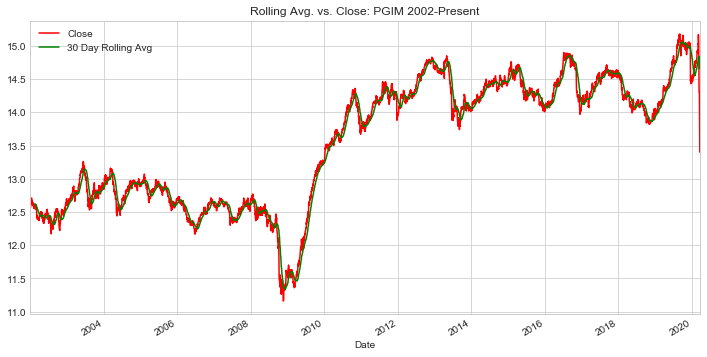

In [18]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,6))
closestocks2002['PGIM Total Return Bond Fund -Class A'].plot(color='red',label='Close',figsize=(12,6))
stockrollingaverage2002['PGIM Total Return Bond Fund -Class A'].plot(color='green', label='30 Day Rolling Avg',figsize=(12,6))
plt.legend()
plt.title('Rolling Avg. vs. Close: PGIM 2002-Present')
plt.show()

In [19]:
#rolling statistics stockpercentchange2002,rollavglogdiff2002

In [20]:
closelog2002 = np.log(closestocks2002)

In [21]:
closelog2002['PGIM Total Return Bond Fund -Class A']

Date
2002-01-02    2.529721
2002-01-03    2.531313
2002-01-04    2.530517
2002-01-07    2.534490
2002-01-08    2.534490
                ...   
2020-03-16    2.660959
2020-03-17    2.640485
2020-03-18    2.608598
2020-03-19    2.595255
2020-03-20    2.595255
Name: PGIM Total Return Bond Fund -Class A, Length: 4586, dtype: float64

In [22]:
logr2002 = (closelog2002-closelog2002.shift(1))

In [23]:
cumsumlog2002 = np.cumsum(logr2002)

In [24]:
reconstructlogpercent2002 = np.exp(cumsumlog2002) 

In [25]:
reconstructstock = reconstructlogpercent2002*closestocks2002.loc['2002-01-02']

In [26]:
logtoreturn2002 = pd.concat([closestocks2002,closelog2002,logr2002,reconstructlogpercent2002,reconstructstock],axis=1,keys=['Close','Log','Log Diff Shift','Log Percent','Reconstructed Stock'])

In [27]:
logtoreturn2002

Close                                    \
Bank Ticker Treasury 5 Year Index Hartford Core Equity Fund Class Y   
Date                                                                  
2002-01-02                  4.466                         11.440000   
2002-01-03                  4.437                         11.510000   
2002-01-04                  4.439                         11.570000   
2002-01-07                  4.336                         11.500000   
2002-01-08                  4.329                         11.480000   
...                           ...                               ...   
2020-03-16                  0.492                         26.750000   
2020-03-17                  0.650                         28.350000   
2020-03-18                  0.820                         26.930000   
2020-03-19                  0.648                         26.950001   
2020-03-20                  0.520                         25.700001   

                                                  \
Bank Ticker PGIM Total Return Bond Fund -Class A   
Date                                               
2002-01-02                                 12.55   
2002-01-03                                 12.57   
2002-01-04                                 12.56   
2002-01-07                                 12.61   
2002-01-08                                 12.61   
...                                          ...   
2020-03-16                                 14.31   
2020-03-17                                 14.02   
2020-03-18                                 13.58   
2020-03-19                                 13.40   
2020-03-20                                 13.40   

                                                                       Log  \
Bank Ticker American Funds Capital World Growth, R-4 Treasury 5 Year Index   
Date                                                                         
2002-01-02                                       NaN              1.496493   
2002-01-03                                       NaN              1.489978   
2002-01-04                                       NaN              1.490429   
2002-01-07                                       NaN              1.466952   
2002-01-08                                       NaN              1.465337   
...                                              ...                   ...   
2020-03-16                                 37.680000             -0.709277   
2020-03-17                                 39.200001             -0.430783   
2020-03-18                                 37.029999             -0.198451   
2020-03-19                                 37.389999             -0.433865   
2020-03-20                                 36.860001             -0.653927   

                                               \
Bank Ticker Hartford Core Equity Fund Class Y   
Date                                            
2002-01-02                           2.437116   
2002-01-03                           2.443216   
2002-01-04                           2.448416   
2002-01-07                           2.442347   
2002-01-08                           2.440606   
...                                       ...   
2020-03-16                           3.286534   
2020-03-17                           3.344627   
2020-03-18                           3.293241   
2020-03-19                           3.293983   
2020-03-20                           3.246491   

                                                  \
Bank Ticker PGIM Total Return Bond Fund -Class A   
Date                                               
2002-01-02                              2.529721   
2002-01-03                              2.531313   
2002-01-04                              2.530517   
2002-01-07                              2.534490   
2002-01-08                              2.534490   
...                                          ...   
2020-03-16                              2.660959   
2020

In [28]:
stockrollingaverage2002 = closestocks2002.rolling(window=30).mean().dropna()
stockrollingaverage2016 = closestocks2016.rolling(window=30).mean().dropna()

In [29]:
stockrollingaveragelog2002 = np.log(stockrollingaverage2002).dropna()
stockrollingaveragelog2016 = np.log(stockrollingaverage2016).dropna()

In [30]:
stockrollingstd2002 = closestocks2002.rolling(window=30).std().dropna()
stockrollingstd2016 = closestocks2016.rolling(window=30).std().dropna()

In [31]:
shift5dayavg = closelog2002.rolling(window=5).mean()

In [32]:
shift5dayavg['PGIM Total Return Bond Fund -Class A'].dropna(inplace=True)

In [33]:
def get_stationarityPGIM(timeseries):
    # rolling statistics plot
    plt.plot(closestocks2002['PGIM Total Return Bond Fund -Class A'], color='blue', label='Original')
    plt.plot(stockrollingaverage2002['PGIM Total Return Bond Fund -Class A'], color='red', label='Rolling Mean')
    plt.plot(stockrollingstd2002['PGIM Total Return Bond Fund -Class A'], color='black', label='Rolling Std')
    plt.plot(stockrollingaveragelog2002['PGIM Total Return Bond Fund -Class A'],color='green', label='Rolling Mean Log')
    plt.plot(closelog2002['PGIM Total Return Bond Fund -Class A'],color='orange', label='closelog2002')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation, \n PGIM Total Return Bond Fund -Class A')
    plt.show(block=False)
    
    print('\n')
    result = adfuller(closelog2002['PGIM Total Return Bond Fund -Class A'])
    print('PGIM Total Return Bond Fund -Class A')
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

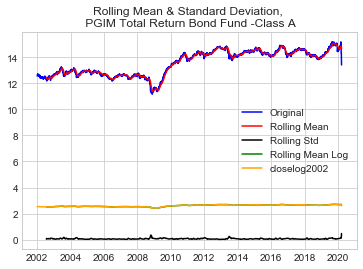



PGIM Total Return Bond Fund -Class A
ADF Statistic: -1.6053453703877212
p-value: 0.48090780977147235
Critical Values:
	1%: -3.4317782837918727
	5%: -2.8621711342851617
	10%: -2.5671059557268925


In [34]:
get_stationarityPGIM(closelog2002['PGIM Total Return Bond Fund -Class A'])

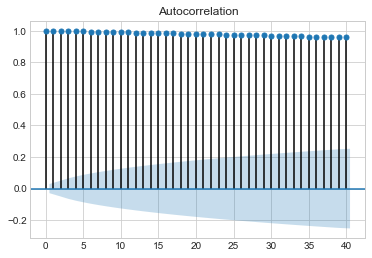

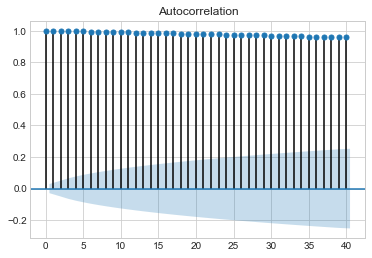

In [35]:
plot_acf(closelog2002['PGIM Total Return Bond Fund -Class A'].loc['2002-01-10':yesterday],lags=40)

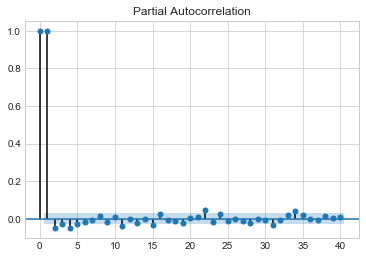

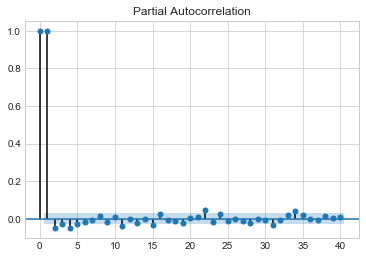

In [36]:
plot_pacf(closelog2002['PGIM Total Return Bond Fund -Class A'].loc['2002-01-10':yesterday],lags=40)

In [37]:
exogdata = shift5dayavg['PGIM Total Return Bond Fund -Class A'].loc['2002-01-10':yesterday]

In [38]:
exogdata = pd.DataFrame(exogdata)

In [39]:
arma_order_select_ic(closelog2002['PGIM Total Return Bond Fund -Class A'].loc['2002-01-10':yesterday])

C:\Users\matth\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

C:\Users\matth\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\matth\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\matth\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\matth\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



{'bic':               0             1             2
 0 -11289.428809 -17381.532595 -22561.818772
 1 -41635.934924 -41638.742995 -41632.397851
 2 -41639.262663 -41648.989937 -41611.228543
 3 -41633.550317 -41640.639152 -41621.281837
 4 -41637.429924 -41634.156398 -41625.931989, 'bic_min_order': (2, 1)}

In [40]:
endog = closelog2002['PGIM Total Return Bond Fund -Class A'].loc['2002-01-10':yesterday]
exog = shift5dayavg['PGIM Total Return Bond Fund -Class A'].loc['2002-01-10':yesterday]
arimamodel = ARIMA(endog,order=(2,0,1),exog=exog,dates=date_list)
arimamodelfit = arimamodel.fit(disp=0)
predictions = arimamodelfit.predict()
predictions = predictions.sort_index()
print(arimamodelfit.summary())

C:\Users\matth\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                                       ARMA Model Results                                       
Dep. Variable:     PGIM Total Return Bond Fund -Class A   No. Observations:                 4580
Model:                                       ARMA(2, 1)   Log Likelihood               21845.068
Method:                                         css-mle   S.D. of innovations              0.002
Date:                                  Sun, 22 Mar 2020   AIC                         -43678.136
Time:                                          14:45:00   BIC                         -43639.560
Sample:                                      03-20-2020   HQIC                        -43664.555
                                           - 03-17-2030                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
co

In [41]:
start_index = date_list[0]
end_index = date_list[-1]
logrforecast = arimamodelfit.predict(start=start_index, end=end_index,exog=exog)
logrforecast.head(-5)

2020-03-20    2.534376
2020-03-21    2.538926
2020-03-22    2.541614
2020-03-23    2.541837
2020-03-24    2.542851
                ...   
2030-03-08    2.683442
2030-03-09    2.687445
2030-03-10    2.687293
2030-03-11    2.689366
2030-03-12    2.690220
Freq: D, Length: 3645, dtype: float64

In [42]:
logrforecast = pd.DataFrame(logrforecast,columns=['PGIM Total Return Bond Fund -Class A'])
closelog2002 = pd.DataFrame(closelog2002['PGIM Total Return Bond Fund -Class A'],columns=['PGIM Total Return Bond Fund -Class A'])

In [43]:
PGIMFORECAST = pd.concat([closelog2002,logrforecast],axis=0)

In [44]:
PGIMFORECAST

,PGIM Total Return Bond Fund -Class A
2002-01-02,2.529721
2002-01-03,2.531313
2002-01-04,2.530517
2002-01-07,2.534490
2002-01-08,2.534490
...,...
2030-03-13,2.693614
2030-03-14,2.698144
2030-03-15,2.697671
2030-03-16,2.699711


In [45]:
PGIMFORECAST.index = pd.to_datetime(PGIMFORECAST.index)

In [46]:
#iplot
PGIMFORECAST.iplot(title='PGIM Total Return Bond Fund -Class A: Stock Close Price ARIMA Predictions',xTitle='Close Date',yTitle='Log Stock',colors='black')

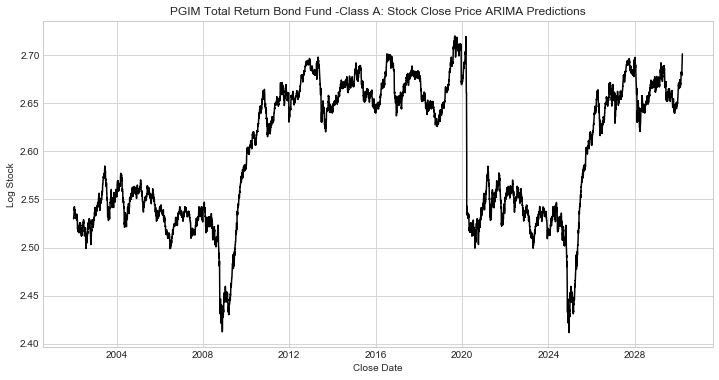

In [47]:
plt.figure(figsize=(12,6))
plt.plot(PGIMFORECAST,color='black')
plt.title('PGIM Total Return Bond Fund -Class A: Stock Close Price ARIMA Predictions')
plt.xlabel('Close Date')
plt.ylabel('Log Stock')
plt.show()

In [48]:
stockreconstructedforecast2 = np.exp(PGIMFORECAST['PGIM Total Return Bond Fund -Class A'])

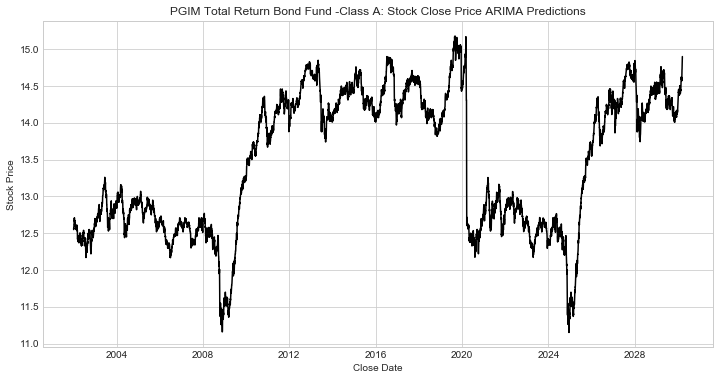

In [49]:
plt.figure(figsize=(12,6))
plt.plot(stockreconstructedforecast2,color='black')
plt.title('PGIM Total Return Bond Fund -Class A: Stock Close Price ARIMA Predictions')
plt.xlabel('Close Date')
plt.ylabel('Stock Price')
plt.show()

In [50]:
#iplot
stockreconstructedforecast2.iplot(title='PGIM Total Return Bond Fund -Class A: Stock Close Price ARIMA Predictions',xTitle='Close Date',yTitle='Stock Price',colors='black')